## Modeling Notebook

In [75]:
# General Packages
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from yahooquery import Ticker
from tqdm import tqdm

# SK-Learn Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# CNN Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.regularizers import l2
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC, F1Score

In [5]:
# Reading in most recent data
stock_data = pd.read_csv('data/WithCashFlowDataNoOutliers.csv')
stock_data.drop(['Index'], axis = 1, inplace = True)
stock_data.dropna(inplace = True)
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
0,A,166.5,14,138.09,4.088458e+10,0.206,1,4.930681e+10,6.848000e+09,1.985000e+09,0.10102,80000000.0,529000000.0,1.353000e+09,41000000.0
1,AA,50.0,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09,0.05931,-231000000.0,299000000.0,8.220000e+08,0.0
2,AAN,16.0,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08,0.06360,0.0,403930000.0,1.704320e+08,0.0
3,AAOI,3.4,4,2.11,6.130162e+07,0.611,1,9.875690e+07,2.228180e+08,-3.543400e+07,-0.08548,24643000.0,11253000.0,-1.402200e+07,0.0
4,AAP,155.0,17,120.21,7.122887e+09,0.289,1,9.181402e+09,1.115472e+10,9.909550e+08,0.03891,0.0,156733000.0,7.222220e+08,0.0


In [41]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
count,2136.000000,2136.000000,2136.000000,2.136000e+03,2136.000000,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2136.000000,2.136000e+03,2.136000e+03,2.136000e+03,2.136000e+03
mean,68.737004,9.224719,57.130066,8.593780e+09,0.699404,0.590824,1.009959e+10,3.756765e+09,7.172493e+08,-0.043569,3.178887e+07,4.478589e+08,5.049861e+08,2.450304e+06
std,135.298078,4.647385,123.570656,1.785242e+10,1.155297,0.569473,1.992935e+10,7.018417e+09,1.436034e+09,0.199080,1.349144e+08,1.004820e+09,1.034982e+09,9.799373e+07
min,0.600000,4.000000,0.240000,2.822783e+07,-0.151000,-1.000000,4.259801e+07,0.000000e+00,-9.360000e+08,-1.000000,-4.180000e+08,-1.514000e+09,-5.137450e+08,-1.710000e+09
25%,13.500000,5.000000,8.092500,6.621685e+08,0.132000,0.000000,1.143221e+09,2.161578e+08,-3.682400e+07,-0.096987,0.000000e+00,6.043031e+06,-2.850175e+07,0.000000e+00
50%,32.000000,8.000000,23.620000,2.354210e+09,0.286000,1.000000,3.160352e+09,1.036120e+09,1.823625e+08,0.022365,0.000000e+00,9.987600e+07,1.190055e+08,0.000000e+00
75%,78.000000,12.000000,64.187500,7.147960e+09,0.666250,1.000000,8.739960e+09,4.018505e+09,8.048250e+08,0.060735,7.383500e+06,4.685705e+08,5.648008e+08,0.000000e+00
max,2800.000000,20.000000,2615.600000,1.972006e+11,8.231000,1.000000,2.271751e+11,1.091200e+11,1.257500e+10,0.238460,1.309928e+09,8.335000e+09,7.762000e+09,2.518713e+09


In [58]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2136 entries, 0 to 2152
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 2136 non-null   object 
 1   AveragePriceTarget     2136 non-null   float64
 2   NumRatings             2136 non-null   int64  
 3   ClosingPrice           2136 non-null   float64
 4   MarketCap              2136 non-null   float64
 5   ExpectedGrowthRate     2136 non-null   float64
 6   OverallRecommendation  2136 non-null   int64  
 7   ProjectedMarketCap     2136 non-null   float64
 8   TotalRevenue           2136 non-null   float64
 9   NormEBITDA             2136 non-null   float64
 10  ReturnOnAssets         2136 non-null   float64
 11  ChangeNormEBITDA       2136 non-null   float64
 12  ChangeRevenue          2136 non-null   float64
 13  OperatingCashFlow      2136 non-null   float64
 14  ChangeOCF              2136 non-null   float64
dtypes: f

In [71]:
stock_data['ExpectedGrowthRate'].sort_values(ascending=False)

1839    8.231
425     8.130
192     7.993
1334    7.871
2016    7.766
        ...  
430    -0.120
1799   -0.127
1919   -0.130
451    -0.136
612    -0.151
Name: ExpectedGrowthRate, Length: 2136, dtype: float64

We're now ready to set up our first model

### Random Forest Classifier

In [6]:
modeling_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','OverallRecommendation']]
modeling_df.set_index('Ticker', inplace = True)

In [7]:
X = modeling_df.drop(['OverallRecommendation'], axis = 1)
y = modeling_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

In [12]:
# Smote to address class imbalance
smt = SMOTE(random_state = 42)
# Scaling Data
ss = StandardScaler()
# Principal Component Analysis to address Multicolinearity
pca = PCA(n_components = 5)
# Instantiate Model, Pipeline
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('pca', pca),('random_forest', rfc)])

0.5771846051666205


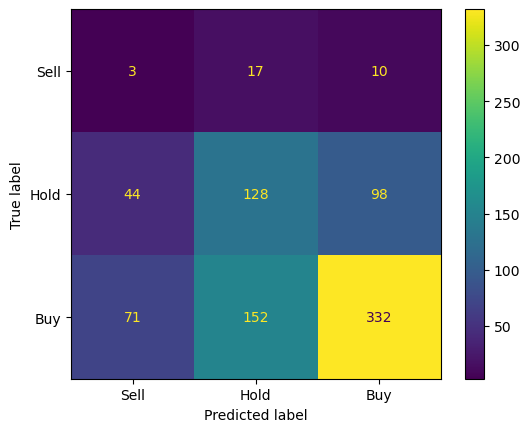

In [14]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average = 'weighted')
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()

Hyper Parameter Tuning

In [29]:
rfc_params = {'random_forest__max_depth': [15,20,25,30,35], 'random_forest__n_estimators': [50,55,60,65,70]}
score = make_scorer(f1_score, average='weighted')

In [30]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = score, verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=5)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [15, 20, 25, 30, 35],
                         'random_forest__n_estimators': [50, 55, 60, 65, 70]},
             scoring=make_scorer(f1_score, average=weighted), verbose=1)

In [31]:
gs.best_params_

{'random_forest__max_depth': 25, 'random_forest__n_estimators': 60}

In [32]:
gs.best_score_

0.6010892057738241

Updating Parameters

In [33]:
rfc = RandomForestClassifier(max_depth = 25, n_estimators = 60, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('pca', pca),('random_forest', rfc)])

0.5797842443675321


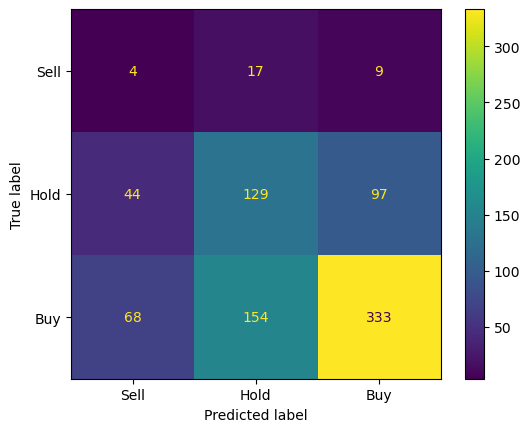

In [57]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average = 'weighted')
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Hold','Buy']).plot()

### Convolutional Neural Network

Preprocessing Data

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, random_state= 42)

In [47]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# PCA
#pca = PCA(n_components = 5)
#X_train_ready = pca.fit_transform(X_train_resampled)
#X_test_ready = pca.transform(X_test_scaled)

# Reshaping Data
X_train_ready = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Map labels to non-negative integers
y_train_mapped = y_train_resampled + 1
y_test_mapped = y_test + 1

# Encode labels
y_train_encoded = to_categorical(y_train_mapped)
y_test_encoded = to_categorical(y_test_mapped)

In [48]:
X_test_ready.shape

(855, 7, 1)

In [49]:
# Creating Neural Network Function
def create_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[F1Score(average='weighted')])
#   history = model.fit(X_train, y_train_encoded, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test_encoded))
    return model

In [54]:
model = create_model()
model.fit(X_train_ready, y_train_encoded, epochs=5, validation_data=(X_test_ready, y_test_encoded))

Epoch 1/5
75/75 [==============================] - 3s 11ms/step - loss: 133476856.0000 - f1_score: 0.4320 - val_loss: 1.2136 - val_f1_score: 0.5287
Epoch 2/5
75/75 [==============================] - 0s 6ms/step - loss: 71523184.0000 - f1_score: 0.4440 - val_loss: 1.2035 - val_f1_score: 0.5150
Epoch 3/5
75/75 [==============================] - 0s 7ms/step - loss: 43099072.0000 - f1_score: 0.4366 - val_loss: 1.1736 - val_f1_score: 0.5114
Epoch 4/5
75/75 [==============================] - 0s 7ms/step - loss: 26812362.0000 - f1_score: 0.4452 - val_loss: 1.1831 - val_f1_score: 0.5114
Epoch 5/5
75/75 [==============================] - 0s 6ms/step - loss: 14290584.0000 - f1_score: 0.4520 - val_loss: 1.1864 - val_f1_score: 0.5114


## Modeling for Expected Growth Rate

In [111]:
modeling_growth_df = stock_data[['Ticker', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','ChangeOCF','ExpectedGrowthRate']]
modeling_growth_df.set_index('Ticker', inplace = True)

In [112]:
X = modeling_growth_df.drop(['ExpectedGrowthRate'], axis = 1)
y = modeling_growth_df['ExpectedGrowthRate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

#### Linear Regression Baseline Model

In [114]:
linreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
linreg_pipeline.fit(X_train, y_train)

# Evaluate pipeline on testing data
y_pred = linreg_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 1.0695022933677487


In [115]:
y_pred.shape

(534,)

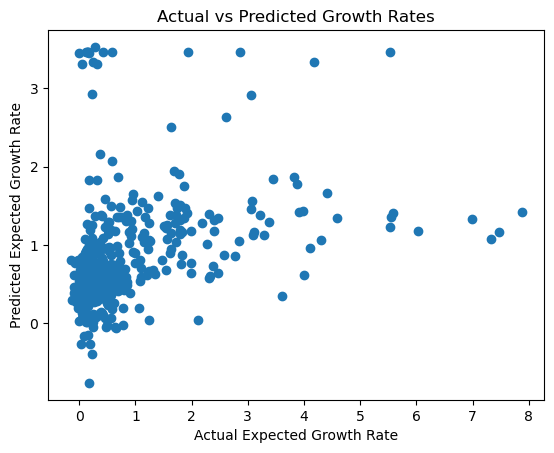

In [116]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Growth Rates')
plt.show()